In [1]:
import numpy as np
bases = ['A', 'C', 'G', 'T']
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

# Load data

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
# file result of bedtools intersect -loj
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [4]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)

37110
169182


In [5]:
import pandas
mercer = pandas.ExcelFile('../anno/mercer.Supplemental_TableS1.xlsx')

In [6]:
print mercer.sheet_names
support = mercer.parse('Split-Invert Alignment')
supp = {}
for chrom, pos, strand in zip(support['Chromosome'], support['Start'], support['Strand']):
    if chrom not in supp: supp[chrom] = {}
    supp[chrom][pos] = 1

[u'Match Only', u'Match+Error', u'Match+Insertion', u'Match+Deletion', u'Split-Invert Alignment']


In [7]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns, supp):
    X, y, chroms, coords, strands = [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')
        
        X += [onehot(seq).reshape(1, L, 4)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            assert int(bp) in supp[chrom]
            if strand == '+':
                bp = L + bp - three
            else:
                bp = L - bp + three - 1
            _y[bp] = 1
            
        for i in range(L-2):
            if strand == '+':
                coord = three - L + i
            else:
                coord = L - i + three - 1
            if (not _y[i]) and (coord in supp[chrom]):
                _y[i] = -1
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords), np.array(strands))

X, y, chroms, coords, strands = encode(known, supp)

coords = coords[chroms == 'chr1']
strands = strands[chroms == 'chr1']
print np.sum(y == 1)
print np.sum(y == -1)
print X.shape

56808
35610
(37110, 70, 4)


In [8]:
test = np.array(map(lambda x: x == 'chr1', chroms))
valid = np.array(map(lambda x: x in ('chr2', 'chr3', 'chr4', 'chr5'),
                     chroms))
train = np.array([not (t or v) for t, v in zip(test, valid)])
print sum(test),  sum(valid), sum(train)

X_train, X_valid, X_test = X[train], X[valid], X[test]
y_train, y_valid, y_test = y[train], y[valid], y[test]
print X_train.shape, X_valid.shape, X_test.shape
print y_train.shape, y_valid.shape, y_test.shape

4306 7093 25711
(25711, 70, 4) (7093, 70, 4) (4306, 70, 4)
(25711, 70) (7093, 70) (4306, 70)


# Sanity Check

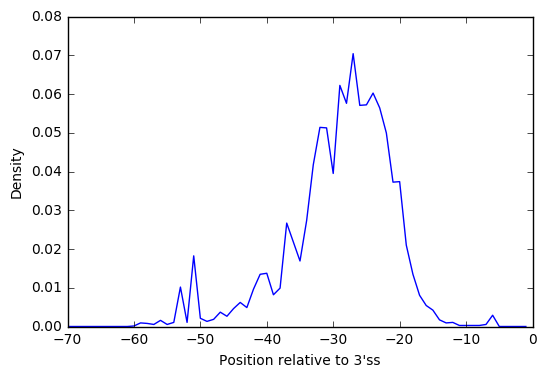

In [9]:
counts = np.zeros((L,))
total = 0
for target, seq in zip(y_test, X_test):
    for bp in np.array(range(L))[target == 1]:
        counts[bp] += 1
        total += 1
dists = counts / float(total)
plt.plot(range(-70, 0), dists)
plt.ylabel('Density')
plt.xlabel("Position relative to 3'ss")
plt.show()

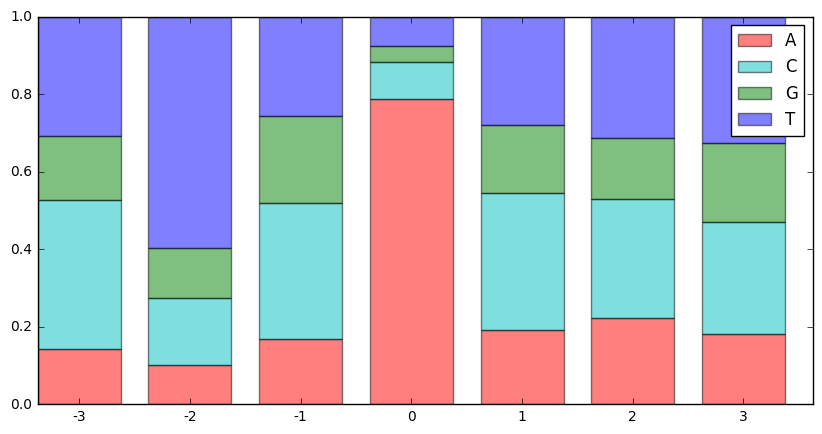

In [10]:
def pwm_logo(pwm, title = ''):
    f, ax1 = plt.subplots(1, figsize=(10,5))
    bar_width = 0.75
    bar_l = [i+1 for i in range(pwm.shape[0])]
    tick_pos = [i+(bar_width/2) for i in bar_l]

    for i, (char, color) in enumerate(zip(['A', 'C', 'G', 'T'],
                                 ['r', 'c','g', 'b'])):
        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                pwm[:, i],
                width=bar_width,
                label=char,
                bottom=np.sum(pwm[:, :i], axis = 1),
                alpha=0.5,
                color = color)
    plt.xticks(tick_pos, range(-K, K+1))
    plt.legend()
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()
    
K = 3
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.array(range(L))[target == 1]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
pwm = counts / total
pwm_logo(pwm)

# Load model and make predictions

In [11]:
from keras.models import load_model
model = load_model('../models/2layer.h5')
test_preds = model.predict(X_test[:, :, :4]).reshape(-1, 70)

Using Theano backend.


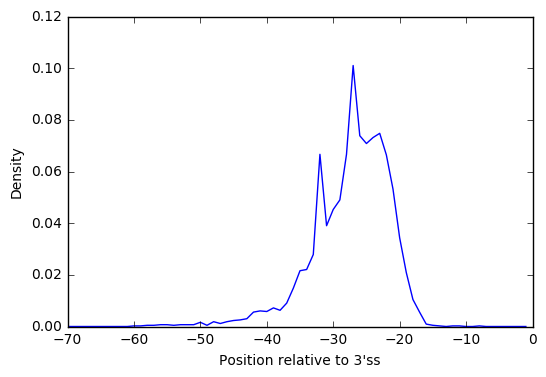

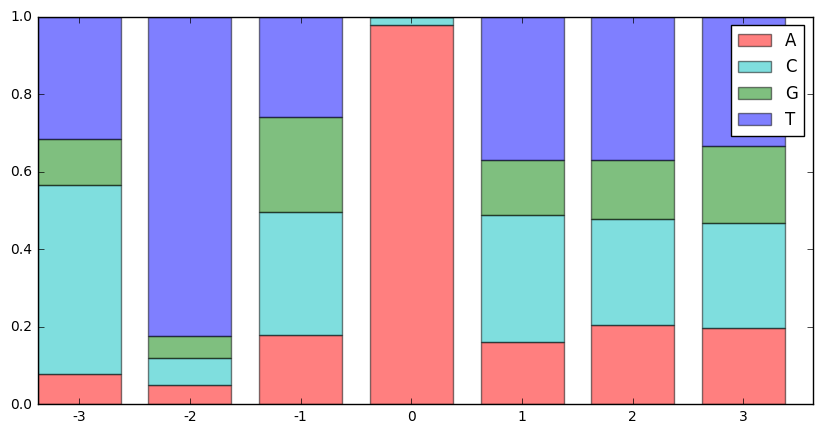

In [12]:
# Sanity Check LaBranchoR preds
counts = np.zeros((L,))
total = 0
for target, seq in zip(test_preds, X_test):
    if np.max(target) == -float('inf'): continue
    bp = np.argmax(target)
    counts[bp] += 1
    total += 1
dists = counts / float(total)
plt.plot(range(-70, 0), dists)
plt.ylabel('Density')
plt.xlabel("Position relative to 3'ss")
plt.show()

K = 3
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(test_preds, X_test):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
pwm = counts / total
pwm_logo(pwm)

# Load SVM-BPFinder Predictions

- Cloned current version of SVM-BPFinder from https://bitbucket.org/regulatorygenomicsupf/svm-bpfinder.
- Produced fasta file of length 70 intronic sequences aligned to 3'ss using labranchor/create_fasta.py using hg19 and gencode v19.
- Ran SVM-BPFinder with command "svm-bpfinder/svm_bpfinder.py -i labranchor/gencode.v19.fa -s Hsap -d 15 > svm-bpfinder.tsv"

In [13]:
bpfinder = np.zeros(test_preds.shape)
bpfinder.fill(-float('inf'))
with open('../svm-bpfinder.tsv') as fp:
    print fp.readline()
    for line in fp:
        coord, agez, dist = line.split('\t')[:3]
        chrom, three, strand = coord.split(':')
        dist, three = int(dist), int(three)
        
        if strand == '-': three += 1
        score = float(line.split('\t')[-1])
        if chrom == 'chr1' and three in coords:
            assert 0 < dist < 70
            bpfinder[np.argwhere(coords==three)[0], -dist] = score

print sum(np.max(bpfinder, axis = 1) > -float('inf'))
print sum(np.max(bpfinder, axis = 1) > 0)
print sum(np.max(bpfinder, axis = 1) > 1.5)

seq_id	agez	ss_dist	bp_seq	bp_scr	y_cont	ppt_off	ppt_len	ppt_scr	svm_scr

4199
3797
988


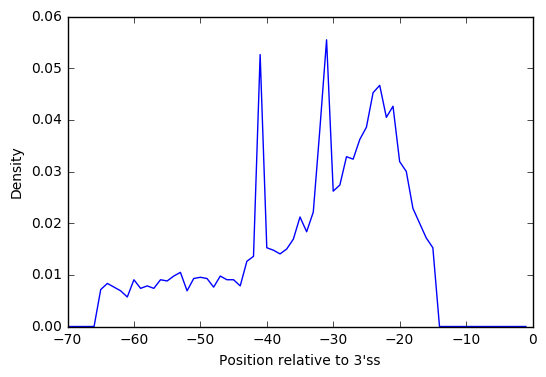

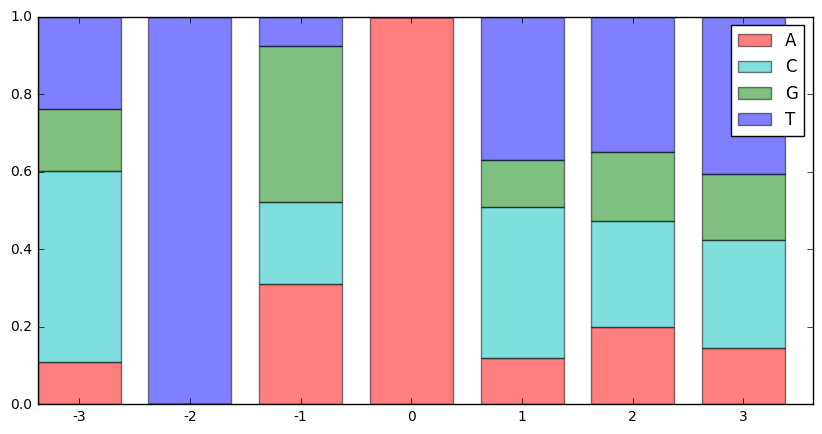

In [14]:
# Sanity Check SVM-BPFinder preds
counts = np.zeros((L,))
total = 0
for target, seq in zip(bpfinder, X_test):
    if np.max(target) == -float('inf'): continue
    bp = np.argmax(target)
    counts[bp] += 1
    total += 1
dists = counts / float(total)
plt.plot(range(-70, 0), dists)
plt.ylabel('Density')
plt.xlabel("Position relative to 3'ss")
plt.show()

K = 3
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(bpfinder, X_test):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
pwm = counts / total
pwm_logo(pwm)

# Model Performance

In [15]:
def shifted_matching(preds, true, title):
    E, B = 4, 4
    total, match, low_match, low_shifted, shifted = 0, 0, 0, 0, 0
    for p, t in zip(preds, true):
        if not np.sum(t==1): continue
        bp = np.argmax(p)
        if bp in np.array(range(preds.shape[1]))[t == 1]:
            match += 1
        elif any(i in np.array(range(preds.shape[1]))[t == 1]
                 for i in range(bp-E, bp+B+1)):
            shifted += 1
        ### above is high conf, below is low conf
        if bp in np.array(range(preds.shape[1]))[t != 0]:
            low_match += 1
        elif any(i in np.array(range(preds.shape[1]))[t != 0]
                 for i in range(bp-E, bp+B+1)):
            low_shifted += 1
            
        total += 1
    heights = [match / float(total),  low_match / float(total),
               (match+shifted) / float(total),
               (low_match+low_shifted) / float(total),
              ]
    return total, heights

In [16]:
def adjustFigAspect(fig,aspect=1):
    '''
    Adjust the subplot parameters so that the figure has the correct
    aspect ratio.
    '''
    xsize,ysize = fig.get_size_inches()
    minsize = min(xsize,ysize)
    xlim = .4*minsize/xsize
    ylim = .4*minsize/ysize
    if aspect < 1:
        xlim *= aspect
    else:
        ylim /= aspect
    fig.subplots_adjust(left=-.1-xlim,
                        right=.1+xlim,
                        bottom=.5-ylim,
                        top=.5+ylim)

def plt_aspect(aspect):
    fig = plt.figure()
    adjustFigAspect(fig,aspect=aspect)
    return fig.add_subplot(111)

def performance(lstm_h, bptr_h, totals, labels, title):
    step = .1
    sig_x, sig_y = [], []
    idx = np.linspace(0, step * len(labels), len(labels))
    for i, label in enumerate(labels):
        odds, pvalue =  fisher_exact([[lstm_h[i]*totals[i],
                                       totals[i]-lstm_h[i]*totals[i]],
                                      [bptr_h[i]*totals[i],
                                       totals[i]-bptr_h[i]*totals[i]]],
                                     'greater')
        print pvalue
        if pvalue < .05:
            sig_x += [idx[i]]
            sig_y += [.02+max(lstm_h[i], bptr_h[i])]
            
    plt_aspect(1.5)
            
    
    plt.scatter(sig_x, sig_y, marker = '*')
    plt.bar(idx-step/4,
            lstm_h, step/2.0, align = 'center', alpha = 0.5,  color = 'green', label = 'LaBranchoR')
    plt.bar(idx+step/4,
            bptr_h, step/2.0, align = 'center', alpha = 0.5, label = 'SVM-BPFinder')
    plt.xlim(0-step/1.5, step * len(labels) + step/1.5)
    plt.ylim(0, 1)
    plt.xticks(idx, labels)
    plt.yticks([0], [''])#np.linspace(.5, .95, 10))
    #plt.ylabel("Fraction matching experimental branchpoint")
    plt.yticks(np.linspace(0, 1, 11), np.linspace(0, 1, 11))
    plt.title(title)
    plt.legend(loc = 4)
    plt.show()
    
def compare(idx, title, start, end):
    lstm   = test_preds[idx, start:end]
    bptr   = bpfinder[idx, start:end]
    
    y_filt = y_test[idx, start:end]
    filt_chroms, filt_coords, filt_strand = chroms[chroms == 'chr1'][idx], coords[idx], strands[idx]

    lstm_t, lstm_h = shifted_matching(lstm, y_filt, 'Labranchor')
    bptr_t, bptr_h = shifted_matching(bptr, y_filt, 'SVM-BPFinder')
    assert lstm_t == bptr_t
    performance(lstm_h, bptr_h, [lstm_t]*4, labels, title)
    
    print 'Totals'
    print lstm_t, bptr_t
    print 'LaBranchoR'
    print lstm_h
    print 'SVM-BPFinder'
    print bptr_h

# Compare to SVM-BPFinder

4306
7.72428710162e-114
2.3477075744e-122
8.04806336512e-148
5.00586225156e-136


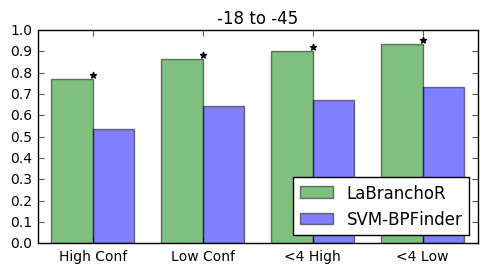

Totals
4114 4114
LaBranchoR
[0.7717549829849295, 0.8648517258142927, 0.9015556635877492, 0.9331550802139037]
SVM-BPFinder
[0.5357316480311133, 0.6448711716091395, 0.6728245017015071, 0.7352941176470589]
1.6191116829e-159
7.93824059122e-178
1.78234086264e-212
5.39674851568e-208


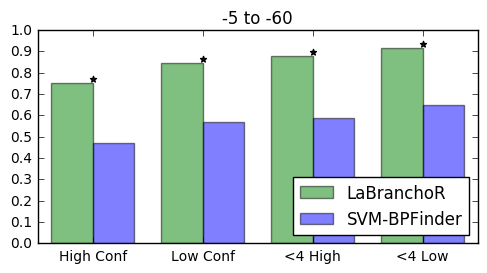

Totals
4306 4306
LaBranchoR
[0.7510450534138412, 0.8457965629354389, 0.8797027403622851, 0.9161634928007432]
SVM-BPFinder
[0.47073850441244774, 0.5715281003251277, 0.5898745935903391, 0.6507199256850905]


In [17]:
from scipy.stats import fisher_exact
labels = ['High Conf','Low Conf','<4 High','<4 Low']

idx = np.max(bpfinder, axis = 1) >= -float('inf')
print sum(idx)
compare(idx, '-18 to -45', -45, -18)
compare(idx, '-5 to -60', -60, -5)

3797
1.48196940196e-81
5.15383063582e-84
4.01431933081e-97
1.20498060988e-83


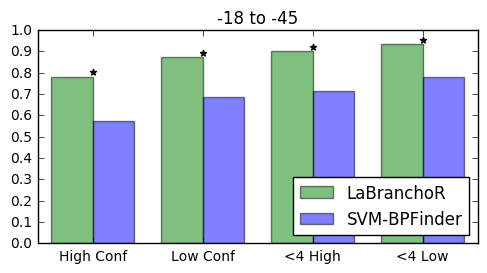

Totals
3630 3630
LaBranchoR
[0.7820936639118458, 0.8743801652892562, 0.9030303030303031, 0.9349862258953168]
SVM-BPFinder
[0.5738292011019284, 0.6884297520661157, 0.7132231404958678, 0.7796143250688705]
1.91872125752e-122
2.39085327301e-132
3.0534422707e-155
8.02427460531e-147


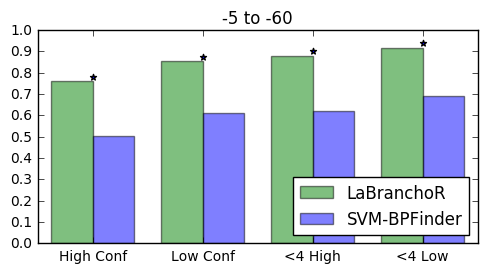

Totals
3797 3797
LaBranchoR
[0.7608638398735844, 0.854885435870424, 0.8809586515670266, 0.9183565973136687]
SVM-BPFinder
[0.5025019752436134, 0.6096918619963129, 0.6228601527521728, 0.6892283381617066]


In [18]:
idx = np.max(bpfinder, axis = 1) >= 0
print sum(idx)
compare(idx, '-18 to -45', -45, -18)
compare(idx, '-5 to -60', -60, -5)

988
8.01509457971e-38
1.67692431413e-33
3.14513801472e-51
4.87689251547e-29


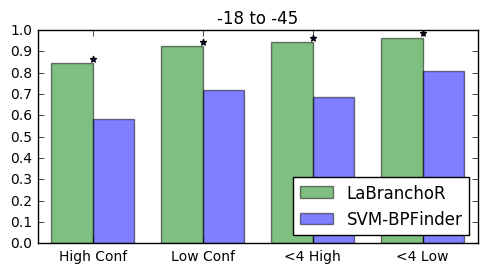

Totals
950 950
LaBranchoR
[0.8442105263157895, 0.9252631578947368, 0.9452631578947368, 0.9652631578947368]
SVM-BPFinder
[0.5810526315789474, 0.7189473684210527, 0.6884210526315789, 0.8094736842105263]
3.43663961659e-47
9.75090499015e-42
2.17694785661e-60
1.84338077983e-36


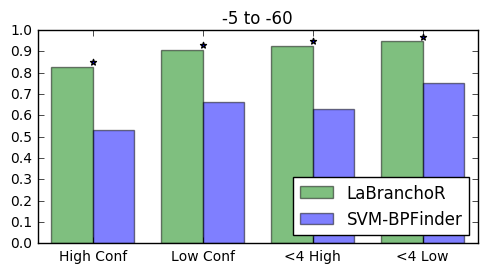

Totals
988 988
LaBranchoR
[0.8289473684210527, 0.9078947368421053, 0.9271255060728745, 0.9483805668016194]
SVM-BPFinder
[0.5303643724696356, 0.6639676113360324, 0.631578947368421, 0.7530364372469636]


In [19]:
idx = np.max(bpfinder, axis = 1) >= 1.5
print sum(idx)
compare(idx, '-18 to -45', -45, -18)
compare(idx, '-5 to -60', -60, -5)

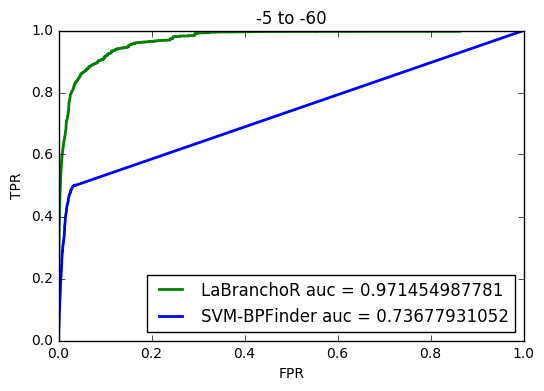

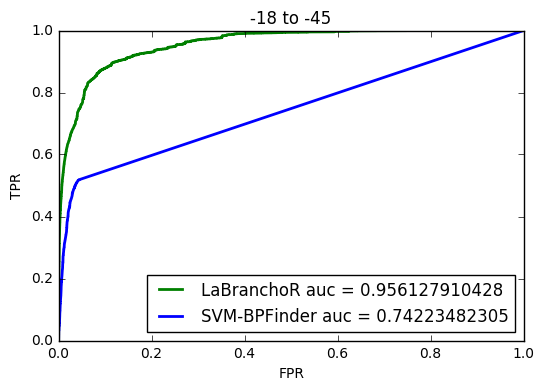

In [20]:
def roc(y, bptr, lstm, title):
    bptr = bptr[np.max(y, axis = 1)>0].flatten()
    lstm = lstm[np.max(y, axis = 1)>0].flatten()
    y = y[np.max(y, axis = 1)>0].flatten()
    
    fpr, tpr, thresholds = metrics.roc_curve(y[y != -1],
                                             lstm[y != -1],
                                             pos_label=1)
    auc = metrics.roc_auc_score(y[y != -1],
                                lstm[y != -1])
    plt.plot(fpr, tpr, label = "LaBranchoR auc = {}".format(auc), lw = 2, c = 'g')

    bptr[bptr == -float('inf')] = -100
    fpr, tpr, thresholds = metrics.roc_curve(y[y != -1],
                                             bptr[y != -1],
                                             pos_label=1)
    auc = metrics.roc_auc_score(y[y != -1],
                                bptr[y != -1])
    plt.plot(fpr, tpr, label = "SVM-BPFinder auc = {}".format(auc), lw = 2, c = 'b')

    plt.legend(loc = 4)
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.title(title)
    plt.show()

roc(y_test, bpfinder, test_preds, '-5 to -60')
roc(y_test[:, -45:-18], bpfinder[:, -45:-18], test_preds[:, -45:-18], '-18 to -45')

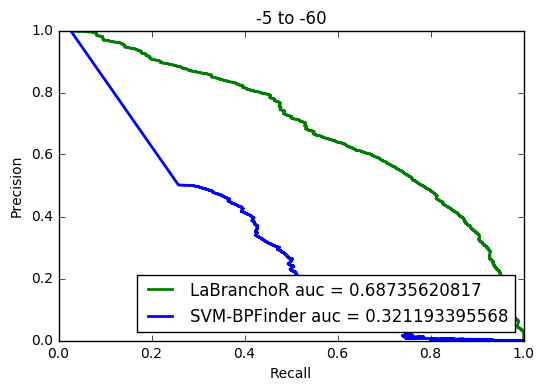

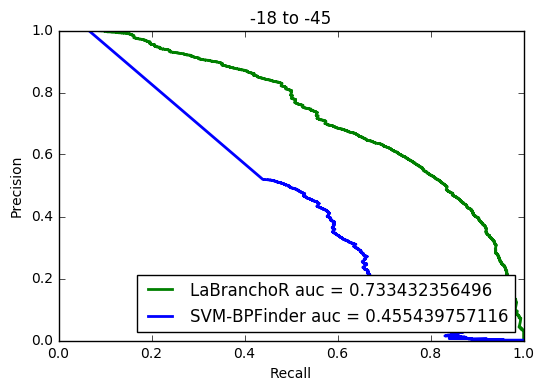

In [21]:
def prc(y, bptr, lstm, title):
    bptr = bptr[np.max(y, axis = 1)>0].flatten()
    lstm = lstm[np.max(y, axis = 1)>0].flatten()
    y = y[np.max(y, axis = 1)>0].flatten()
    
    fpr, tpr, thresholds = metrics.precision_recall_curve(y[y != -1],
                                             lstm[y != -1],
                                             pos_label=1)
    auc = metrics.average_precision_score(y[y != -1],
                                lstm[y != -1])
    plt.plot(fpr, tpr, label = "LaBranchoR auc = {}".format(auc), lw = 2, c = 'g')

    bptr[bptr == -float('inf')] = -100
    fpr, tpr, thresholds = metrics.precision_recall_curve(y[y != -1],
                                             bptr[y != -1],
                                             pos_label=1)
    auc = metrics.average_precision_score(y[y != -1],
                                bptr[y != -1])
    plt.plot(fpr, tpr, label = "SVM-BPFinder auc = {}".format(auc), lw = 2, c = 'b')

    plt.legend(loc = 4)
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.title(title)
    plt.show()

prc(y_test, bpfinder, test_preds, '-5 to -60')
prc(y_test[:, -45:-18], bpfinder[:, -45:-18], test_preds[:, -45:-18], '-18 to -45')